In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42245 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


In [6]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [7]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_IAF',  {'expt':'01deg_jra55v140_iaf','dir':'access-om2-01'})
                        ])

## Just checking the final data for each expt.

In [8]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))
    
end_time = '1990-01-01'
print(' Setting end_time to',end_time)

01deg_jra55v13_ryf9091 goes from 1900 to 2100
01deg_jra55v140_iaf goes from 1958 to 1986
 Setting end_time to 1990-01-01


## Scalar diagnostics

In [6]:
def plot_timeseries(variable,end_time):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 18.9 s, sys: 1.03 s, total: 20 s
Wall time: 26.9 s


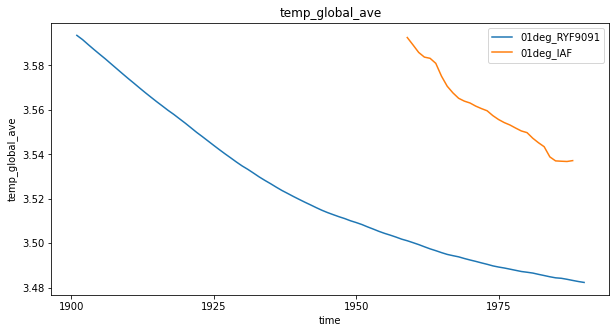

In [7]:
%%time
plot_timeseries('temp_global_ave',end_time)

### Global Average Salinity

CPU times: user 19.2 s, sys: 764 ms, total: 19.9 s
Wall time: 26.4 s


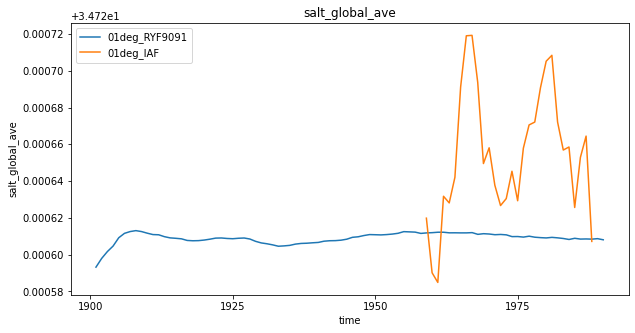

In [8]:
%%time
plot_timeseries('salt_global_ave',end_time)

### Surface Temperature

CPU times: user 20.8 s, sys: 835 ms, total: 21.6 s
Wall time: 29.4 s


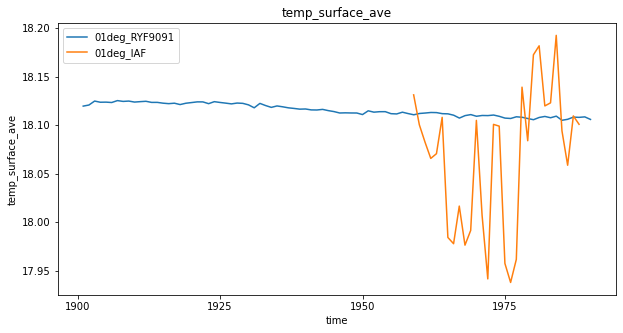

In [9]:
%%time
plot_timeseries('temp_surface_ave',end_time)

### Surface Salinity

CPU times: user 19 s, sys: 751 ms, total: 19.7 s
Wall time: 26.4 s


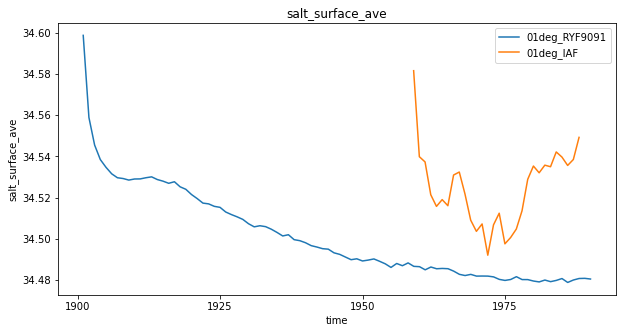

In [10]:
%%time
plot_timeseries('salt_surface_ave',end_time)

### Total Kinetic Energy

CPU times: user 18.7 s, sys: 739 ms, total: 19.5 s
Wall time: 26.2 s


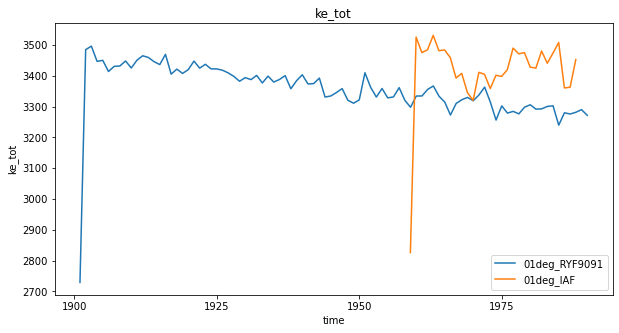

In [11]:
%%time
plot_timeseries('ke_tot',end_time)

## Area-Averaged Tracer Diagnostics

In [9]:
def plot_upper_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

In [ ]:
%%time
plot_upper_ocean('temp',end_time)

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf


01deg_jra55v13_ryf9091
01deg_jra55v140_iaf


distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


KeyboardInterrupt: 

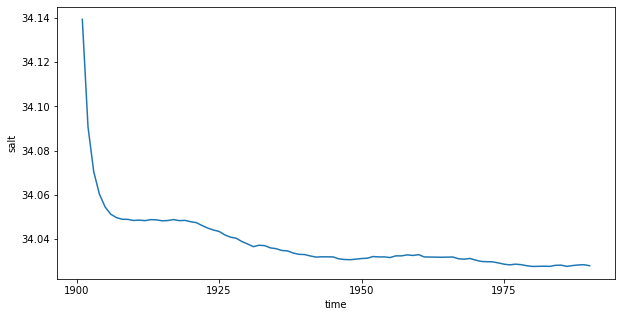

In [11]:
%%time
plot_upper_ocean('salt',end_time)

### Deep Ocean Temperature/Salinity

In [6]:
def plot_lower_ocean(variable,end_time):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        try:
            var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc',end_time=end_time)
        except:
            var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 13min 1s, sys: 44.5 s, total: 13min 46s
Wall time: 18min 12s


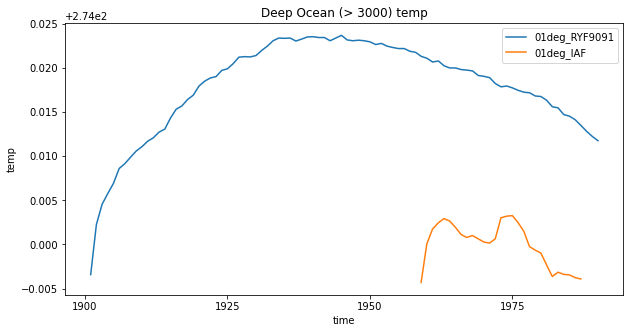

In [7]:
%%time
plot_lower_ocean('temp',end_time)

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 13min 18s, sys: 42 s, total: 14min
Wall time: 18min 17s


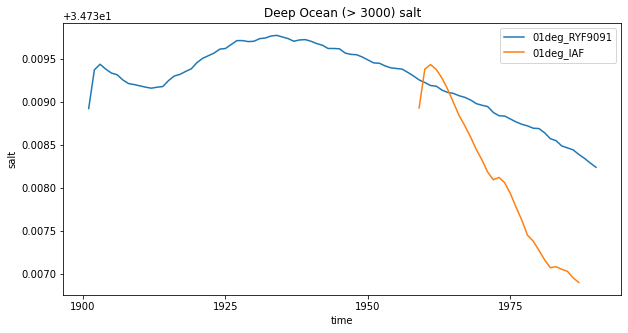

In [8]:
%%time
plot_lower_ocean('salt',end_time)

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 20.6 s, sys: 1.15 s, total: 21.7 s
Wall time: 44 s


Text(0.5, 1.0, 'ACC Transport')

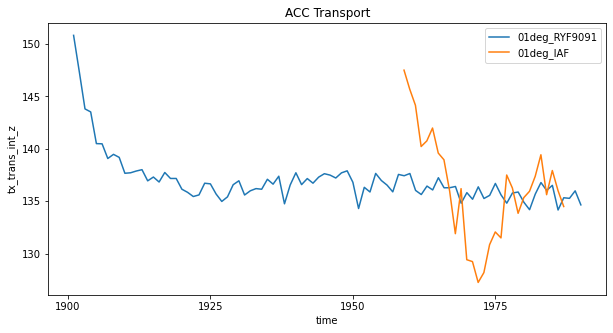

In [7]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

**To Do** - add GM to this.

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 8min 17s, sys: 19.5 s, total: 8min 36s
Wall time: 10min 16s


Text(0.5, 1.0, 'AABW Cell')

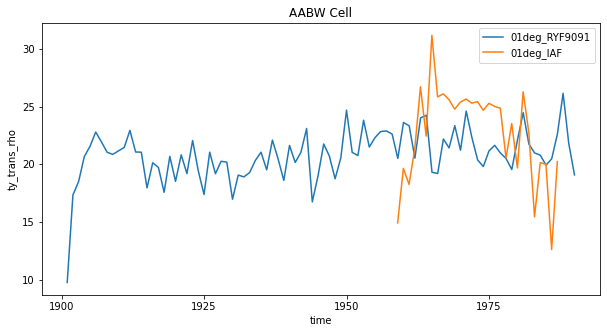

In [8]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
01deg_jra55v140_iaf
CPU times: user 4min 12s, sys: 9.72 s, total: 4min 22s
Wall time: 5min 24s


Text(0.5, 1.0, 'AMOC Cell')

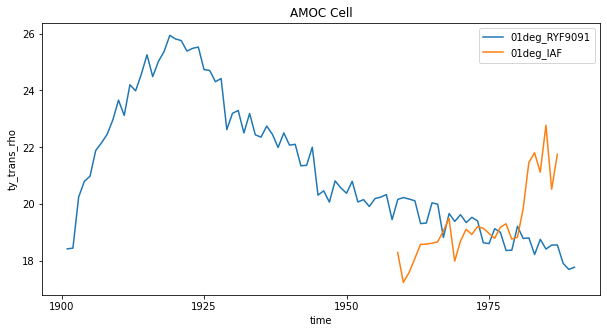

In [9]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,end_time=end_time)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

## Global Overturning Streamfunction

In [12]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [13]:
psi = cc.querying.getvar('01deg_jra55v140_iaf','ty_trans_rho',session,start_time='1975-01-01',end_time='1985-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 2700)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.3307473e-03, -4.0848306e-03, -3.4722153e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.5845327e-03, -4.2481502e-03, -3.5327906e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.7694091e-03, -4.3677813e-03, -3.5635266e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.6376469e-04,  8.2232524e-05,  1.8461840e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.6338107e-05,  1.3387296e-05, -3.0229916e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0

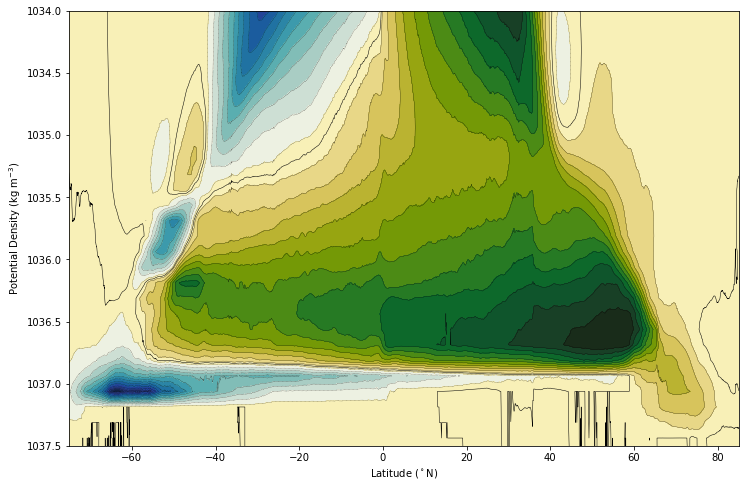

In [14]:
plot_psi(psi_avg)

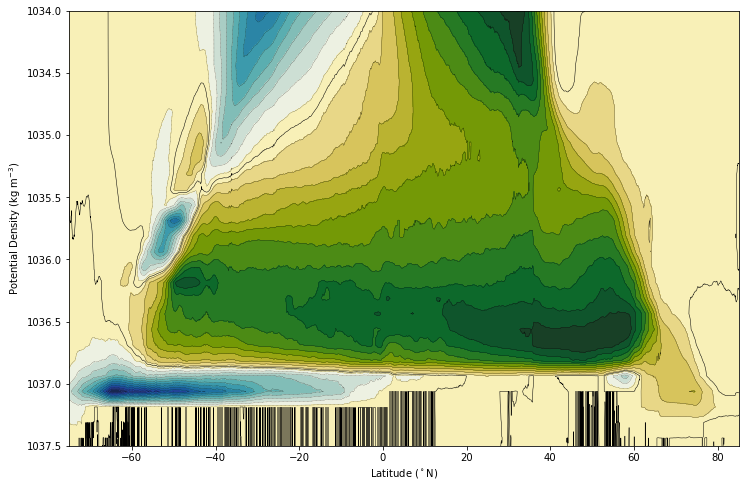

In [33]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2058-01-01', end_time='2067-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

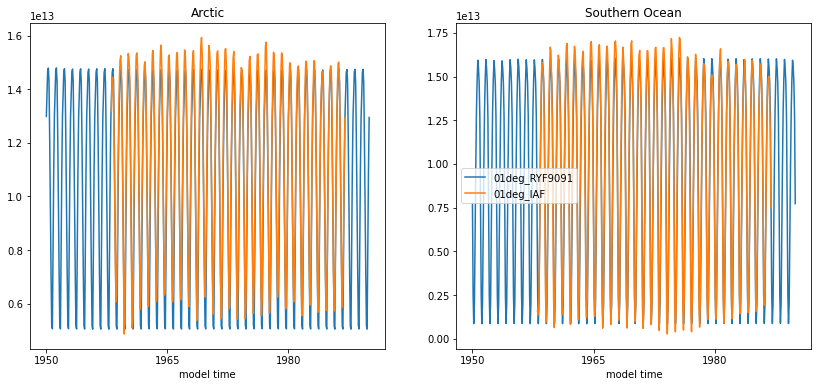

In [10]:
variable='aice_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

Text(0.5, 1.0, 'Southern Ocean')

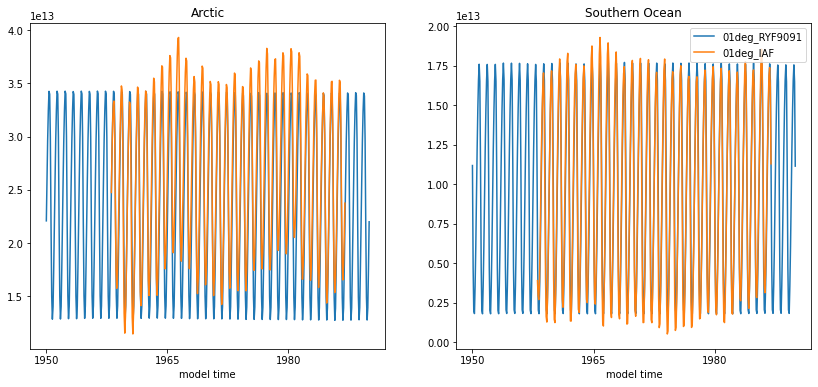

In [11]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,start_time='1950-01-01',end_time=end_time,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')